# Real World Uses Cases Project: Big Data Tools for Business

## Part 2: Real Estate Market Data Exploration in Toulouse and its suburbs

The goal is to perform real estate data exploration near the city of Toulouse.
We have access to a 5-years real data history of houses and apartments sales transactions in Toulouse and its suburbs. The
dataset contains details for each transaction: sale date, localization (city, postalcode), type of residence, type of sale, land area, living area, number of rooms,price, etc.).
We should use Spark for this analysis because we should be able to apply our analysis to a dataset with the entire real estate market in France for instance (bigdata file).
Challenges here are to explore all possible aspects of this real estate market (variables, relationships between variables, trends, patterns, outliers, etc.). We should focus on at least 5 keys findings (tables or visualizations) and can explorefor instance:
- The evolution of the prices (e.g. price per square meter)
- Identification of sales outliers
- Differences of prices per cities or postal codes
- Differences between apartment and houses
- Differences between types of sales
- Differences between Toulouse and its suburbs
- High cost, low cost or emerging cities

In [1]:
import pyspark

spark = pyspark.sql.SparkSession.builder.appName("Toulouse Real Estate Market").getOrCreate()

In [2]:
spark

## Dataset description

The real estate market dataset looks like this. There are 10 different variables for each property:

    Sale Date: the date when the property was sold
    Sale Type: the type of sale
    Price: the price of the transaction (in €)
    Postal Code: the postal code where the property is located
    City: the city where the property is located
    Number of rooms: the number of rooms in the property
    Number of lots: number of tracts or parcels of land related to the property
    Residence type : the type of the property : house or appartment
    Living area: the squared meters in the property
    Land area: the squared meters squared of the garden (if existing)



In [3]:
real_estate_tlse = spark.read.csv('project_data_real_estate_toulouse_and_suburbs.csv', header=True, dateFormat='dd/MM/YYYY', sep=';', encoding='UTF-8',)

real_estate_tlse.show(10)

+----------+--------------------+------+--------+-------------------+-------+------+-------------+----------+--------+
|  SaleDate|            SaleType| Price|PostCode|               City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|
+----------+--------------------+------+--------+-------------------+-------+------+-------------+----------+--------+
|15/01/2019|                SALE| 95000|   31270|VILLENEUVE TOLOSANE|      2|     0|        HOUSE|        45|     505|
|21/01/2019|                SALE|261700|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        87|     311|
|03/01/2019|                SALE|101000|   31270|VILLENEUVE TOLOSANE|      2|     1|    APARTMENT|        44|       0|
|11/01/2019|                SALE| 59500|   31270|VILLENEUVE TOLOSANE|      1|     1|    APARTMENT|        26|       0|
|15/01/2019|                SALE|179000|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        95|     263|
|15/01/2019|                SALE|209300|   31270

In [4]:
real_estate_tlse.printSchema()

root
 |-- SaleDate: string (nullable = true)
 |-- SaleType: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- PostCode: string (nullable = true)
 |-- City: string (nullable = true)
 |-- NbRooms: string (nullable = true)
 |-- NbLots: string (nullable = true)
 |-- ResidenceType: string (nullable = true)
 |-- LivingArea: string (nullable = true)
 |-- LandArea: string (nullable = true)



All the variables are type string : we cretae a new schema with the correct type for each variable

In [5]:
from pyspark.sql.types import *

real_estate_schema = StructType ( [StructField("sale_date", DateType(), True),
                                   StructField("sale_type", StringType(), True),
                                   StructField("price", StringType(), True),
                                   StructField("post_code", IntegerType(), True),
                                   StructField("city", StringType(), True),
                                   StructField("number_rooms", IntegerType(), True),
                                   StructField("number_lots", IntegerType(), True),
                                   StructField("residence_type", StringType(), True),
                                   StructField("living_area", IntegerType(), True),
                                   StructField("land_area", IntegerType(), True)]
                                )    

In [6]:
spark.conf.set("spark.sql.legacy.timeParserPolicy","Legacy")

real_estate_tlse = spark.read.csv('project_data_real_estate_toulouse_and_suburbs.csv', header=True, sep=';', dateFormat='dd/MM/YYYY', schema=real_estate_schema)

from pyspark.sql.functions import regexp_replace
real_estate_tlse = real_estate_tlse.withColumn('price', regexp_replace('price', ',', '.'))
real_estate_tlse = real_estate_tlse.withColumn('price',real_estate_tlse['price'].cast("int").alias('price'))
real_estate_tlse.show(20)

+----------+--------------------+------+---------+-------------------+------------+-----------+--------------+-----------+---------+
| sale_date|           sale_type| price|post_code|               city|number_rooms|number_lots|residence_type|living_area|land_area|
+----------+--------------------+------+---------+-------------------+------------+-----------+--------------+-----------+---------+
|2019-01-15|                SALE| 95000|    31270|VILLENEUVE TOLOSANE|           2|          0|         HOUSE|         45|      505|
|2019-01-21|                SALE|261700|    31270|VILLENEUVE TOLOSANE|           4|          0|         HOUSE|         87|      311|
|2019-01-03|                SALE|101000|    31270|VILLENEUVE TOLOSANE|           2|          1|     APARTMENT|         44|        0|
|2019-01-11|                SALE| 59500|    31270|VILLENEUVE TOLOSANE|           1|          1|     APARTMENT|         26|        0|
|2019-01-15|                SALE|179000|    31270|VILLENEUVE TOLOSANE

In [7]:
real_estate_tlse.createOrReplaceTempView('real_estate_tlse')

In [8]:
real_estate_tlse.printSchema()

root
 |-- sale_date: date (nullable = true)
 |-- sale_type: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- post_code: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- number_rooms: integer (nullable = true)
 |-- number_lots: integer (nullable = true)
 |-- residence_type: string (nullable = true)
 |-- living_area: integer (nullable = true)
 |-- land_area: integer (nullable = true)



In [9]:
real_estate_count = spark.sql("SELECT COUNT(*) FROM real_estate_tlse ")

real_estate_count.show()

+--------+
|count(1)|
+--------+
|   80118|
+--------+



We have 80 118 properties in our dataset = 80 118 lines)

In [10]:
real_estate_price_year = spark.sql("SELECT YEAR(sale_date) AS year, ROUND(AVG(price)) AS avg_price \
                                       FROM real_estate_tlse \
                                       GROUP BY YEAR(sale_date) \
                                       ORDER BY YEAR(sale_date)")

real_estate_price_year.show()

+----+---------+
|year|avg_price|
+----+---------+
|2015| 962999.0|
|2016| 518392.0|
|2017| 554008.0|
|2018| 295983.0|
|2019| 560693.0|
+----+---------+



<AxesSubplot:title={'center':'Average price per year'}, xlabel='year'>

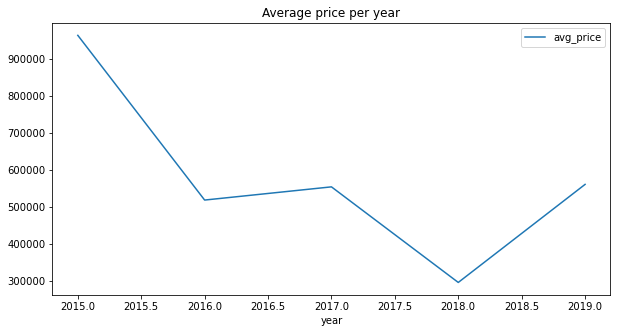

In [11]:
real_estate_price_year.toPandas().plot.line(x='year', y='avg_price', title="Average price per year", figsize=(10,5))

The average price of properties in 2015 seems exaggeratedly high compared to other years. 

In [12]:
real_estate_price_2015 = spark.sql("SELECT * \
                                    FROM real_estate_tlse \
                                    WHERE YEAR(sale_date) = 2015 \
                                    ORDER BY price DESC")
real_estate_price_2015.show(50)

+----------+---------+--------+---------+----------+------------+-----------+--------------+-----------+---------+
| sale_date|sale_type|   price|post_code|      city|number_rooms|number_lots|residence_type|living_area|land_area|
+----------+---------+--------+---------+----------+------------+-----------+--------------+-----------+---------+
|2015-04-08|     SALE|33427218|    31500|  TOULOUSE|           4|          0|     APARTMENT|         83|     3872|
|2015-04-08|     SALE|33427218|    31200|  TOULOUSE|           4|          1|     APARTMENT|         74|        0|
|2015-04-08|     SALE|33427218|    31200|  TOULOUSE|           3|          1|     APARTMENT|         70|        0|
|2015-04-08|     SALE|33427218|    31200|  TOULOUSE|           3|          1|     APARTMENT|         66|        0|
|2015-04-08|     SALE|33427218|    31500|  TOULOUSE|           3|          1|     APARTMENT|         60|        0|
|2015-04-08|     SALE|33427218|    31500|  TOULOUSE|           4|          0|   

-> We have outliers

### Removing outliers

We can see that in 2015 there were many transactions on the same day with an exaggeratedly high price (more than one billion euros for flats) so we can exclude all of these transactions from the dataset as outliers. We decided to set our threshold to 50 milion euros: we don't consider real estate properties with a price higher than this because they're out of our study.

In [13]:
real_estate_tlse = real_estate_tlse.where("price<10000000") 

In [14]:
real_estate_tlse.createOrReplaceTempView('real_estate_tlse')

In [15]:
real_estate_count = spark.sql("SELECT COUNT(*) FROM real_estate_tlse")

real_estate_count.show()

+--------+
|count(1)|
+--------+
|   79349|
+--------+



We removed around 1000 properties with too high price.

### Average price per year

In [16]:
real_estate_price_year = spark.sql("SELECT YEAR(sale_date) AS year, ROUND(AVG(price)) AS avg_price \
                                       FROM real_estate_tlse \
                                       GROUP BY YEAR(sale_date) \
                                       ORDER BY YEAR(sale_date)")

real_estate_price_year.show()

+----+---------+
|year|avg_price|
+----+---------+
|2015| 322487.0|
|2016| 428324.0|
|2017| 438957.0|
|2018| 295244.0|
|2019| 553364.0|
+----+---------+



<AxesSubplot:title={'center':'Average price per year'}, xlabel='year'>

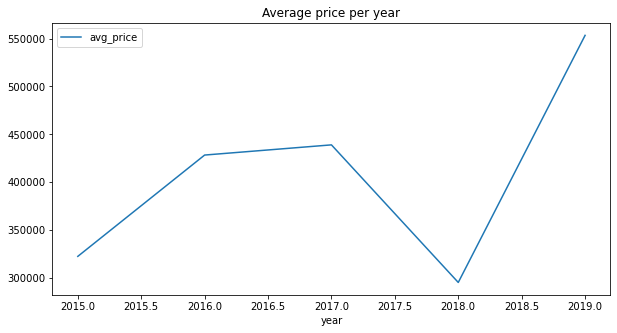

In [17]:
real_estate_price_year.toPandas().plot.line(x='year', y='avg_price', title="Average price per year", figsize=(10,5))

### Correlation between price and living area

<AxesSubplot:title={'center':'Correlation number of rooms and living area'}, xlabel='price', ylabel='living_area'>

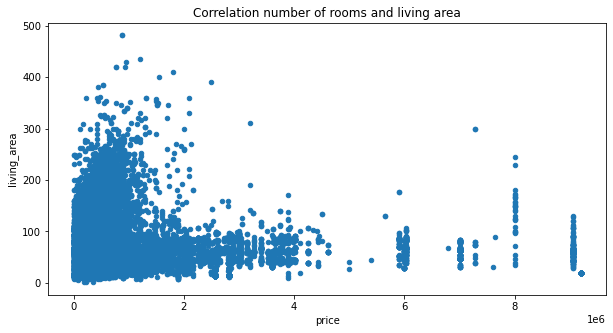

In [18]:
real_estate_tlse.toPandas().plot.scatter(x="price", y="living_area", title="Correlation number of rooms and living area", figsize=(10,5))

We do not see a clear correlation between the price and the living_area.

### Correlation between number of rooms and living area

In [19]:
real_estate_nb_rooms = real_estate_tlse.where("number_rooms>1") 

<AxesSubplot:title={'center':'Correlation number of rooms and living area'}, xlabel='number_rooms', ylabel='living_area'>

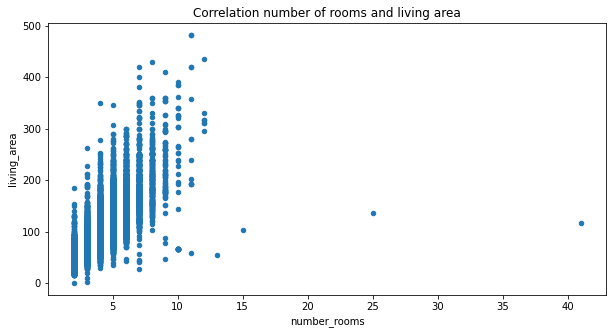

In [20]:
real_estate_nb_rooms.toPandas().plot.scatter(x="number_rooms", y="living_area", title="Correlation number of rooms and living area", figsize=(10,5))

### Average price/m² per year

In [21]:
real_estate_price_squared_meter_year = spark.sql("SELECT YEAR(sale_date) AS year, ROUND(AVG(price/(living_area+land_area))) AS avg_price_squared_meter \
                                                  FROM real_estate_tlse \
                                                  GROUP BY YEAR(sale_date) \
                                                  ORDER BY YEAR(sale_date)")

real_estate_price_squared_meter_year.show()

+----+-----------------------+
|year|avg_price_squared_meter|
+----+-----------------------+
|2015|                 4447.0|
|2016|                 4518.0|
|2017|                 7697.0|
|2018|                 2819.0|
|2019|                 4081.0|
+----+-----------------------+



<AxesSubplot:title={'center':'Average price per squared meter per year'}, xlabel='year'>

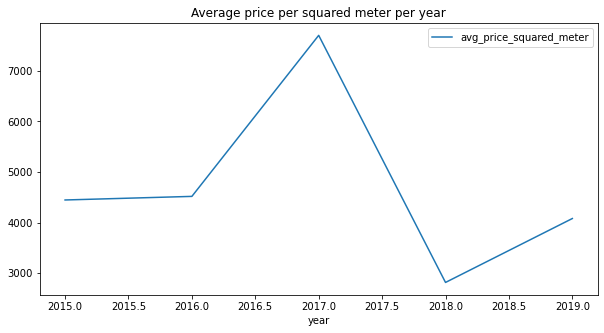

In [22]:
real_estate_price_squared_meter_year.toPandas().plot.line(x='year', y='avg_price_squared_meter', title="Average price per squared meter per year", figsize=(10,5))

### Number of properties per city (Toulouse and its suburbs)

In [23]:
real_estate_properties_per_city = spark.sql("SELECT city, COUNT(*) AS nb_of_properties \
                                             FROM real_estate_tlse \
                                             GROUP BY city \
                                             ORDER BY nb_of_properties DESC")
real_estate_properties_per_city.show()

+--------------------+----------------+
|                city|nb_of_properties|
+--------------------+----------------+
|            TOULOUSE|           51145|
|             BLAGNAC|            5174|
|           COLOMIERS|            2785|
|       TOURNEFEUILLE|            2510|
|             CUGNAUX|            1872|
|               BALMA|            1408|
|               MURET|            1354|
|    CASTANET TOLOSAN|            1317|
|RAMONVILLE-SAINT-...|            1316|
|SAINT-ORENS-DE-GA...|            1147|
|          SAINT-JEAN|            1115|
|  PLAISANCE DU TOUCH|             995|
|          AUCAMVILLE|             969|
|             L UNION|             959|
|            LEGUEVIN|             675|
|        CORNEBARRIEU|             647|
| VILLENEUVE TOLOSANE|             627|
|           BEAUZELLE|             597|
|  PORTET SUR GARONNE|             569|
|              PIBRAC|             537|
+--------------------+----------------+
only showing top 20 rows



### Average price per city

In [24]:
real_estate_price_city = spark.sql("SELECT city, ROUND(AVG(price)) AS avg_price \
                                    FROM real_estate_tlse \
                                    GROUP BY city \
                                    ORDER BY avg_price DESC")

real_estate_price_city.show()

+--------------------+---------+
|                city|avg_price|
+--------------------+---------+
|    VIEILLE TOULOUSE| 570052.0|
|             BLAGNAC| 566726.0|
|               BALMA| 443656.0|
|       TOURNEFEUILLE| 441672.0|
|            TOULOUSE| 400059.0|
|             L UNION| 375906.0|
|             CUGNAUX| 364387.0|
|          FENOUILLET| 361367.0|
|          ESCALQUENS| 357878.0|
|           COLOMIERS| 321439.0|
|          SAINT-JEAN| 320421.0|
|RAMONVILLE-SAINT-...| 308558.0|
|        CORNEBARRIEU| 307784.0|
|              PIBRAC| 305131.0|
|              LABEGE| 304538.0|
|  AUZEVILLE-TOLOSANE| 297756.0|
|SAINT-ORENS-DE-GA...| 290555.0|
|    CASTANET TOLOSAN| 283255.0|
|  PORTET SUR GARONNE| 282096.0|
|   QUINT-FONSEGRIVES| 261051.0|
+--------------------+---------+
only showing top 20 rows



<AxesSubplot:title={'center':'Average price per city'}, xlabel='city'>

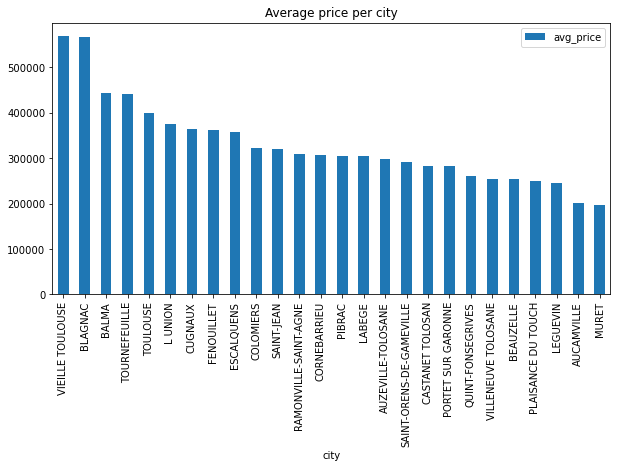

In [25]:
real_estate_price_city.toPandas().plot.bar(x = "city", y="avg_price", title="Average price per city", figsize=(10,5))

We can see that Blagnac and Tournefeuille are big and active market because of the influence of Airbus offices.

### Number of properties per residence type

In [26]:
real_estate_count_local_type = spark.sql("SELECT residence_type, COUNT(*) nb_of_properties \
                                          FROM real_estate_tlse \
                                          GROUP BY residence_type \
                                          ORDER BY nb_of_properties DESC")
real_estate_count_local_type.show()

+--------------+----------------+
|residence_type|nb_of_properties|
+--------------+----------------+
|     APARTMENT|           61778|
|         HOUSE|           17571|
+--------------+----------------+



### Average price per residence type

In [27]:
real_estate_price_local_type = spark.sql("SELECT residence_type, ROUND(AVG(price)) AS avg_price \
                                          FROM real_estate_tlse \
                                          GROUP BY residence_type \
                                          ORDER BY avg_price DESC")
real_estate_price_local_type.show()

+--------------+---------+
|residence_type|avg_price|
+--------------+---------+
|     APARTMENT| 394344.0|
|         HOUSE| 366065.0|
+--------------+---------+



<AxesSubplot:title={'center':'Average price per residence type'}, xlabel='residence_type'>

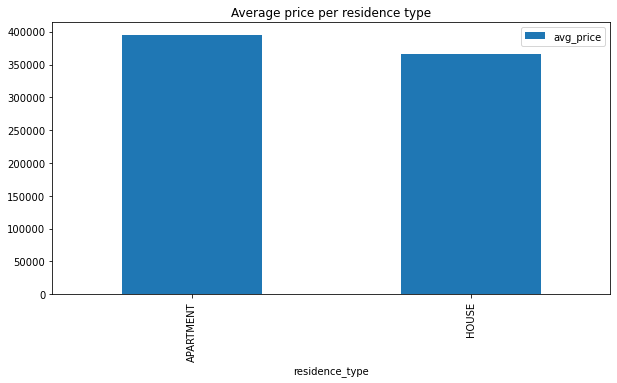

In [28]:
real_estate_price_local_type.toPandas().plot.bar(x = "residence_type", y="avg_price", title="Average price per residence type", figsize=(10,5))

Surprisingly, the apartements are a little more expensive than houses on average.

### Average price of houses per city 

In [29]:
real_estate_price_apartment_city = spark.sql("SELECT city, ROUND(AVG(price)) AS avg_price \
                                              FROM real_estate_tlse \
                                              WHERE residence_type = 'HOUSE' \
                                              GROUP BY city \
                                              ORDER BY avg_price DESC")

real_estate_price_apartment_city.show()

+--------------------+---------+
|                city|avg_price|
+--------------------+---------+
|    VIEILLE TOULOUSE| 572416.0|
|               BALMA| 495508.0|
|            TOULOUSE| 441320.0|
|SAINT-ORENS-DE-GA...| 395831.0|
|  AUZEVILLE-TOLOSANE| 384610.0|
|       TOURNEFEUILLE| 379470.0|
|    CASTANET TOLOSAN| 376630.0|
|              PIBRAC| 373034.0|
|           BEAUZELLE| 359157.0|
|RAMONVILLE-SAINT-...| 341056.0|
|              LABEGE| 338200.0|
|             CUGNAUX| 337488.0|
|   QUINT-FONSEGRIVES| 333348.0|
|          ESCALQUENS| 320993.0|
|             BLAGNAC| 320763.0|
|             L UNION| 306679.0|
|          SAINT-JEAN| 303285.0|
|        CORNEBARRIEU| 290009.0|
|  PLAISANCE DU TOUCH| 289367.0|
|           COLOMIERS| 288163.0|
+--------------------+---------+
only showing top 20 rows



<AxesSubplot:title={'center':'Average price for the apartments per city'}, xlabel='city'>

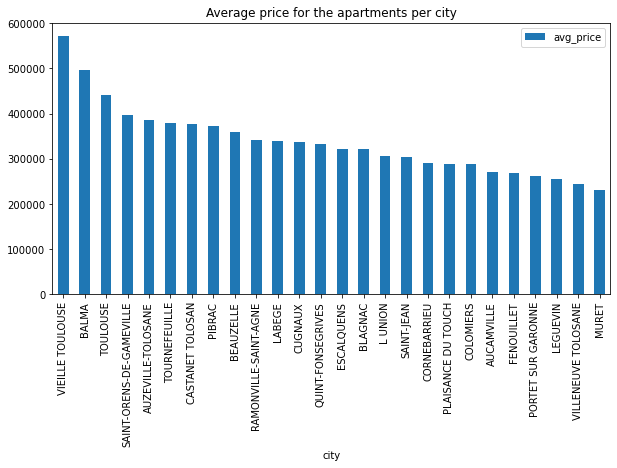

In [30]:
real_estate_price_apartment_city.toPandas().plot.bar(x = "city", y="avg_price", title="Average price for the apartments per city", figsize=(10,5))

### Number of properties per sale type

In [31]:
real_estate_count_sale_type = spark.sql("SELECT sale_type, COUNT(*) nb_of_properties \
                                         FROM real_estate_tlse \
                                         GROUP BY sale_type \
                                         ORDER BY nb_of_properties DESC")
real_estate_count_sale_type.show()

+--------------------+----------------+
|           sale_type|nb_of_properties|
+--------------------+----------------+
|                SALE|           65919|
|SALE BEFORE COMPL...|           13430|
+--------------------+----------------+



### Average price per sale type

In [32]:
real_estate_price_sale_type = spark.sql("SELECT sale_type, ROUND(AVG(price)) AS avg_price \
                                         FROM real_estate_tlse \
                                         GROUP BY sale_type \
                                         ORDER BY avg_price DESC")
real_estate_price_sale_type.show()

+--------------------+---------+
|           sale_type|avg_price|
+--------------------+---------+
|                SALE| 406727.0|
|SALE BEFORE COMPL...| 296568.0|
+--------------------+---------+



<AxesSubplot:title={'center':'Average price per sale type'}, xlabel='sale_type'>

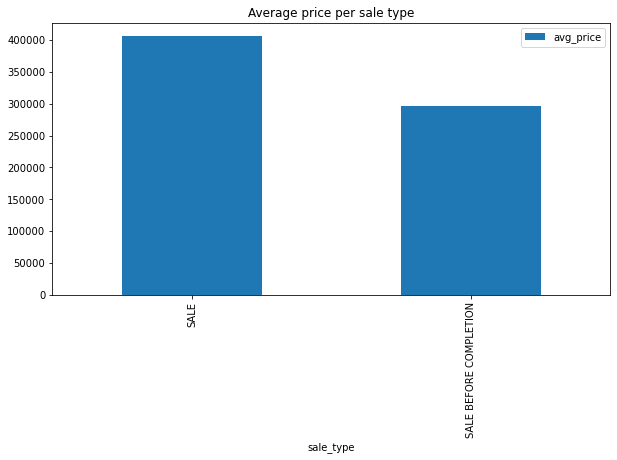

In [33]:
real_estate_price_sale_type.toPandas().plot.bar(x = "sale_type", y="avg_price", title="Average price per sale type", figsize=(10,5))

### Evolution of the average price per city per year

We take the first 6 biggest cities of Toulouse area (Toulouse, Colomiers, Blagnac, Tournefeuille, Balma, Muret)

In [34]:
real_estate_price_city_year_toulouse = spark.sql("SELECT YEAR(sale_date) AS year, ROUND(AVG(price)) AS avg_price_toulouse \
                                               FROM real_estate_tlse \
                                               WHERE city = 'TOULOUSE' \
                                               GROUP BY YEAR(sale_date) \
                                               ORDER BY YEAR(sale_date)")
real_estate_price_city_year_toulouse.show()

real_estate_price_city_year_colomiers = spark.sql("SELECT YEAR(sale_date) AS year, ROUND(AVG(price)) AS avg_price_colomiers \
                                                   FROM real_estate_tlse \
                                                   WHERE city = 'COLOMIERS' \
                                                   GROUP BY YEAR(sale_date) \
                                                   ORDER BY YEAR(sale_date)")
real_estate_price_city_year_colomiers.show()

real_estate_price_city_year_blagnac = spark.sql("SELECT YEAR(sale_date) AS year, ROUND(AVG(price)) AS avg_price_blagnac \
                                                FROM real_estate_tlse \
                                                WHERE city = 'BLAGNAC' \
                                                GROUP BY YEAR(sale_date) \
                                                ORDER BY YEAR(sale_date)")
real_estate_price_city_year_blagnac.show()

real_estate_price_city_year_tournefeuille = spark.sql("SELECT YEAR(sale_date) AS year, ROUND(AVG(price)) AS avg_price_tournefeuille \
                                              FROM real_estate_tlse \
                                              WHERE city = 'TOURNEFEUILLE' \
                                              GROUP BY YEAR(sale_date) \
                                              ORDER BY YEAR(sale_date)")
real_estate_price_city_year_tournefeuille.show()

real_estate_price_city_year_balma = spark.sql("SELECT YEAR(sale_date) AS year, ROUND(AVG(price)) AS avg_price_balma \
                                                  FROM real_estate_tlse \
                                                  WHERE city = 'BALMA' \
                                                  GROUP BY YEAR(sale_date) \
                                                  ORDER BY YEAR(sale_date)")
real_estate_price_city_year_balma.show()

real_estate_price_city_year_muret = spark.sql("SELECT YEAR(sale_date) AS year, ROUND(AVG(price)) AS avg_price_muret \
                                                  FROM real_estate_tlse \
                                                  WHERE city = 'MURET' \
                                                  GROUP BY YEAR(sale_date) \
                                                  ORDER BY YEAR(sale_date)")
real_estate_price_city_year_muret.show()

+----+------------------+
|year|avg_price_toulouse|
+----+------------------+
|2015|          292326.0|
|2016|          348594.0|
|2017|          518228.0|
|2018|          314338.0|
|2019|          681390.0|
+----+------------------+

+----+-------------------+
|year|avg_price_colomiers|
+----+-------------------+
|2015|           218314.0|
|2016|           600298.0|
|2017|           200507.0|
|2018|           255208.0|
|2019|           189492.0|
+----+-------------------+

+----+-----------------+
|year|avg_price_blagnac|
+----+-----------------+
|2015|         442607.0|
|2016|        1195035.0|
|2017|         296465.0|
|2018|         233283.0|
|2019|         222382.0|
+----+-----------------+

+----+-----------------------+
|year|avg_price_tournefeuille|
+----+-----------------------+
|2015|               529911.0|
|2016|               535574.0|
|2017|               349340.0|
|2018|               313374.0|
|2019|               326882.0|
+----+-----------------------+

+----+---------

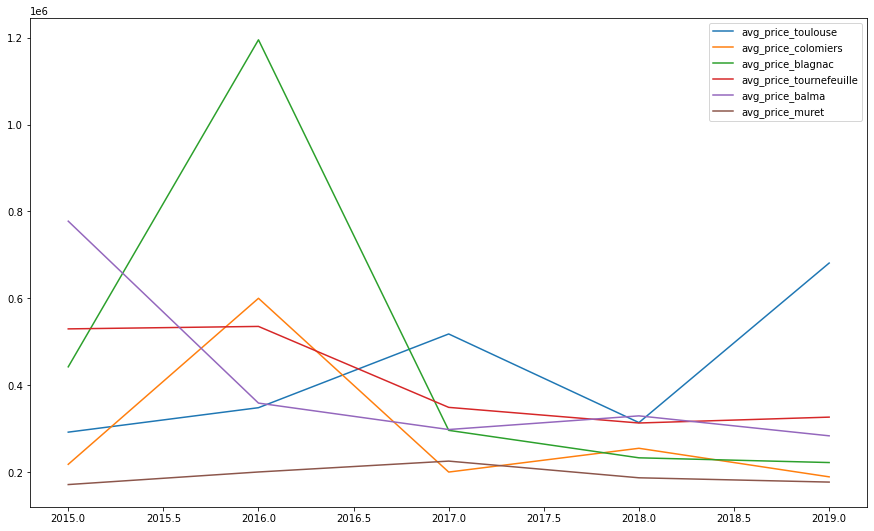

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,9))
plt.plot('year', 'avg_price_toulouse', data=real_estate_price_city_year_toulouse.toPandas())
plt.plot('year', 'avg_price_colomiers', data=real_estate_price_city_year_colomiers.toPandas())
plt.plot('year', 'avg_price_blagnac', data=real_estate_price_city_year_blagnac.toPandas())
plt.plot('year', 'avg_price_tournefeuille', data=real_estate_price_city_year_tournefeuille.toPandas())
plt.plot('year', 'avg_price_balma', data=real_estate_price_city_year_balma.toPandas())
plt.plot('year', 'avg_price_muret', data=real_estate_price_city_year_muret.toPandas())
plt.legend()

We notice that on average the prices have decreased for the cities in the suburbs of Toulouse while the prices in Toulouse have increased.

### Evolution of the number of properties per city per year

In [36]:
real_estate_count_city_year_toulouse = spark.sql("SELECT YEAR(sale_date) AS year, COUNT(*) AS nb_of_properties_toulouse \
                                               FROM real_estate_tlse \
                                               WHERE city = 'TOULOUSE' \
                                               GROUP BY YEAR(sale_date) \
                                               ORDER BY YEAR(sale_date)")
real_estate_count_city_year_toulouse.show()

real_estate_count_city_year_colomiers = spark.sql("SELECT YEAR(sale_date) AS year, COUNT(*) AS nb_of_properties_colomiers \
                                                   FROM real_estate_tlse \
                                                   WHERE city = 'COLOMIERS' \
                                                   GROUP BY YEAR(sale_date) \
                                                   ORDER BY YEAR(sale_date)")
real_estate_count_city_year_colomiers.show()

real_estate_count_city_year_blagnac = spark.sql("SELECT YEAR(sale_date) AS year, COUNT(*) AS nb_of_properties_blagnac \
                                                FROM real_estate_tlse \
                                                WHERE city = 'BLAGNAC' \
                                                GROUP BY YEAR(sale_date) \
                                                ORDER BY YEAR(sale_date)")
real_estate_count_city_year_blagnac.show()

real_estate_count_city_year_tournefeuille = spark.sql("SELECT YEAR(sale_date) AS year, COUNT(*) AS nb_of_properties_tournefeuille \
                                              FROM real_estate_tlse \
                                              WHERE city = 'TOURNEFEUILLE' \
                                              GROUP BY YEAR(sale_date) \
                                              ORDER BY YEAR(sale_date)")
real_estate_count_city_year_tournefeuille.show()

real_estate_count_city_year_balma = spark.sql("SELECT YEAR(sale_date) AS year, COUNT(*) AS nb_of_properties_balma \
                                                  FROM real_estate_tlse \
                                                  WHERE city = 'BALMA' \
                                                  GROUP BY YEAR(sale_date) \
                                                  ORDER BY YEAR(sale_date)")
real_estate_count_city_year_balma.show()

real_estate_count_city_year_muret = spark.sql("SELECT YEAR(sale_date) AS year, COUNT(*) AS nb_of_properties_muret \
                                                  FROM real_estate_tlse \
                                                  WHERE city = 'MURET' \
                                                  GROUP BY YEAR(sale_date) \
                                                  ORDER BY YEAR(sale_date)")
real_estate_count_city_year_muret.show()

+----+-------------------------+
|year|nb_of_properties_toulouse|
+----+-------------------------+
|2015|                    11329|
|2016|                    11544|
|2017|                    13436|
|2018|                    10753|
|2019|                     4083|
+----+-------------------------+

+----+--------------------------+
|year|nb_of_properties_colomiers|
+----+--------------------------+
|2015|                       515|
|2016|                       740|
|2017|                       740|
|2018|                       616|
|2019|                       174|
+----+--------------------------+

+----+------------------------+
|year|nb_of_properties_blagnac|
+----+------------------------+
|2015|                    1516|
|2016|                    1386|
|2017|                    1226|
|2018|                     812|
|2019|                     234|
+----+------------------------+

+----+------------------------------+
|year|nb_of_properties_tournefeuille|
+----+------------------------

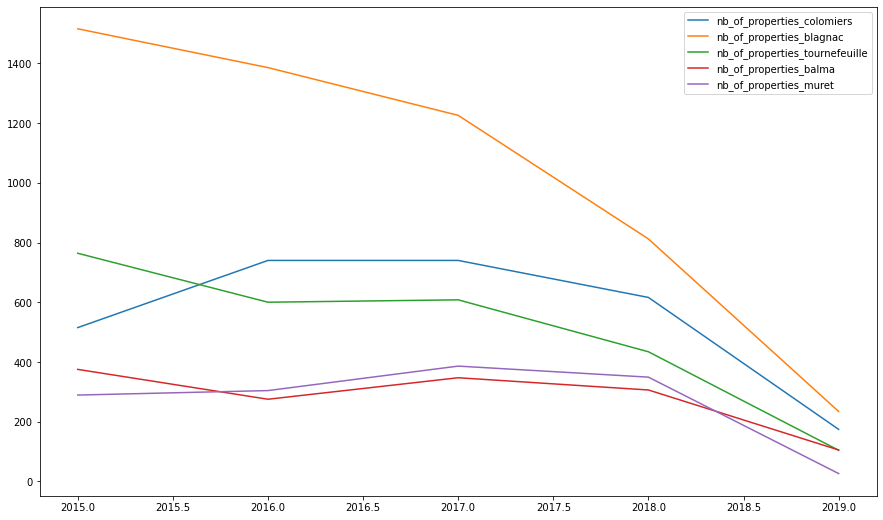

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,9))
#plt.plot('year', 'nb_of_properties_toulouse', data=real_estate_count_city_year_toulouse.toPandas())
plt.plot('year', 'nb_of_properties_colomiers', data=real_estate_count_city_year_colomiers.toPandas())
plt.plot('year', 'nb_of_properties_blagnac', data=real_estate_count_city_year_blagnac.toPandas())
plt.plot('year', 'nb_of_properties_tournefeuille', data=real_estate_count_city_year_tournefeuille.toPandas())
plt.plot('year', 'nb_of_properties_balma', data=real_estate_count_city_year_balma.toPandas())
plt.plot('year', 'nb_of_properties_muret', data=real_estate_count_city_year_muret.toPandas())
plt.legend()

We notice a big decrease on the real estate market in 2018-2019. This may be due to a really bad conjuncture, or to a lack of data for these years. 
If we consider that this is a result of missing data, we should stop our analysis in 2018. 

We identified sale outliers of transactions with exaggeratedly high selling prices and decided to exclude properties selling at more than 10 millions euros from our study to have a more acurate sample of the Toulouse real estate market to study. 

We nevertheless did not see any clear trend between prices & living areas when looking at all the transactions. Same for land areas.

The evolution of average price per square meter over years shows that the market peaked in 2018, but went back to its previous values in 2019. <br>

The most dynamic markets of this study are the big cities around Toulouse and near Airbus (Blagnac, Colomiers, Tournefeuille, Pibrac...).<br>

Surprisingly, the apartements are a little more expensive than houses on average.<br>

**Those are our conclusions :**
- **Immo-Inv should not specifically focus on the living area and land area when investing in properties.**
- **Larger properties with more rooms seem to be in general not more expensive.** 
- **2019 would be a good year to invest in real estate for Immo-Inv, but Immo-Inv has to study the conjecture of 2018.**
- **Focus on cities near Airbus where the demand is high.**
- **Toulouse is still attractive.**


